Hotels Review Data Cleaning

In [441]:
import os

os.chdir('/Users/sarahrymorris/downloads')
print(os.getcwd())

/Users/sarahrymorris/Downloads


My Purpose for this Project:

Hello and welcome to my attempt to clean two very (dirty?) datasets scraped from booking.com and tripadvisor.com. I love to travel, eat good food, and try new places - but I will never go anywhere without doing some research ahead of time. I'm known among my friends and family for spending hours scouring reviews across the web before booking a hotel or a reservation. However, after spending so many hours reading reviews - everything starts to blend together. And how do you know which reviews to trust? I began to wonder if I could use some Python to analyze and figure out how to determine if there are some commonalities between the hotels with the highest ratings on Trip Advisor or Booking.com.

A note on the actual code:

The majority of this project consists of cleaning these datasets and getting them into a usable format to run basic analysis on them.
Unfortunately, the two datasets, once merged, only share 6 hotels in common so I wasn't able to perform sentiment analysis on the actual reviews. Oh well! At least there's an opportunity for my next project.

In [444]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [445]:
#Read in the Datasets
booking = pd.read_csv("booking_hotel.csv", engine = "python")
tripadvisor = pd.read_csv("tripadvisor_room.csv", engine = "python")

In [446]:
#Overview of Booking Dataset
booking.info()
booking.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3465 entries, 0 to 3464
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Hotel Name                                 3465 non-null   object 
 1   Location                                   3465 non-null   object 
 2   Rating                                     3365 non-null   object 
 3   Review Score                               3359 non-null   object 
 4   Number of                                  3359 non-null   object 
 5   Room    Score                              2709 non-null   float64
 6   Room Type                                  3465 non-null   object 
 7   Bed Type                                   3449 non-null   object 
 8   Room Price (in BDT or any other currency)  3465 non-null   object 
dtypes: float64(1), object(8)
memory usage: 243.8+ KB


,Hotel Name,Location,Rating,Review Score,Number of,Room Score,Room Type,Bed Type,Room Price (in BDT or any other currency)
0,Krabi La Playa Resort - SHA Plus,Ao Nang Beach,8.2,Very Good,141,8.6,Deluxe Double or Twin Room,1 double or 2 twins,"†146,026"
1,KC Beach Club & Pool Villas,"Chaweng City Center , Chaweng",7.1,Good,193,NaN,Double Room with Balcony and Sea View,1 queen bed,"†215,304"
2,Rawai VIP Villas & Kids Park,Rawai Beach,8.3,Very Good,63,8.9,2 Bedroom Pool Villa,2 queen beds,"†435,384"
3,"FuramaXclusive Sathorn, Bangkok","Bang Rak, Bangkok",7.7,Good,"1,304",8.1,Executive Double Room,1 full bed,"†146,240"
4,Bo Phut Resort and Spa - SHA Plus,Bophut,9.3,Wonderful,294,9.6,Villa with Garden View,1 double or 2 twins,"†621,072"


In [447]:
#Overview of Trip Advisor Dataset
tripadvisor.info()
tripadvisor.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4477 entries, 0 to 4476
Data columns (total 4 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   property name                              4477 non-null   object
 1   Room Price (in BDT or any other currency)  3131 non-null   object
 2   review_count                               4477 non-null   object
 3   Comment about room                         3473 non-null   object
dtypes: object(4)
memory usage: 140.0+ KB


,property name,Room Price (in BDT or any other currency),review_count,Comment about room
0,1. SALA Samui Choengmon Beach Resort,"†45,854","2,820","The breakfast is excellent, the pools are real..."
1,"2. Napasai, A Belmond Hotel, Koh Samui","†29,666","1,191","We a had perfect view at the beach,"
2,3. Pimalai Resort and Spa,"†31,667","3,287",It has everything
3,4. Avani+ Mai Khao Phuket Suites & Villas,"†23,887",144,the villa was very
4,5. Sheraton Samui Resort,"†18,816","1,006",Me & my wife stayed there for 3 Nights and we ...


In [448]:
#Show column names for Both Datasets
booking.columns
tripadvisor.columns

Index(['property name ', 'Room Price (in BDT or any other currency)',
       'review_count', 'Comment about room'],
      dtype='object')

In [449]:
#Hmm, the column names are all over the place.. let's change them to a more standardized format
booking = booking.rename(columns={'Hotel Name': 'hotel_name', 'Location': 'location', 'Rating': 'rating', 'Review Score': 'review_score', 'Number of   ': 'num_reviews', 'Room    Score': 'room_score', 'Room Type': 'room_type', 'Bed Type': 'bed_type', 'Room Price (in BDT or any other currency)': 'price'})
tripadvisor = tripadvisor.rename(columns={'property name ': 'hotel_name', 'Room Price (in BDT or any other currency)': 'price', 'review_count': 'num_reviews', 'Comment about room': 'review'})

#View Results
booking.head()
tripadvisor.head()

,hotel_name,price,num_reviews,review
0,1. SALA Samui Choengmon Beach Resort,"†45,854","2,820","The breakfast is excellent, the pools are real..."
1,"2. Napasai, A Belmond Hotel, Koh Samui","†29,666","1,191","We a had perfect view at the beach,"
2,3. Pimalai Resort and Spa,"†31,667","3,287",It has everything
3,4. Avani+ Mai Khao Phuket Suites & Villas,"†23,887",144,the villa was very
4,5. Sheraton Samui Resort,"†18,816","1,006",Me & my wife stayed there for 3 Nights and we ...


Now, for the initial Booking Dataset Cleaning:
1. First, there are a lot of random characters in the columns rating, num_reviews, room_score, and price. Let's remove those!
2. Of course, we need to check for NAs (and fill or remove them) in the dataset because this can impede further analysis.
3. We need to change the numeric columns to a numeric type to analyze them.

In [451]:
#remove characters from columns rating, num_reviews, room_score, price
booking['num_reviews'] = booking['num_reviews'].str.extract('(\d+)', expand=False)
booking['rating'] = booking['rating'].str.extract('(\d+)', expand=False)
#booking['room_score'] = booking['room_score'].str.extract('(\d+)', expand=False)
booking['price'] = booking['price'].str.extract('(\d+)', expand=False)

In [452]:
#check for NAs in Df
booking_null = []
booking_null.append(booking['hotel_name'].isnull().sum())
booking_null.append(booking['location'].isnull().sum())
booking_null.append(booking['rating'].isnull().sum())
booking_null.append(booking['review_score'].isnull().sum())
booking_null.append(booking['num_reviews'].isnull().sum())
booking_null.append(booking['room_type'].isnull().sum())
booking_null.append(booking['bed_type'].isnull().sum())
booking_null.append(booking['price'].isnull().sum())
print(booking_null)


[0, 0, 100, 106, 106, 0, 16, 0]


There are 100 null values in "rating", 106 null values in "review_score", 106 null values in "num_reviews", and 16 null values in "bed_type".

In [454]:
#Clean Variables and make data numeric

booking['rating'] = pd.to_numeric(booking['rating'])
booking['num_reviews'] = pd.to_numeric(booking['num_reviews'])
booking['room_score'] = pd.to_numeric(booking['room_score'])
booking['price'] = pd.to_numeric(booking['price'])


In [455]:
#fill null values for rating, review_score, num_reviews, bed_type
booking['rating'] = booking['rating'].fillna(0)
booking['review_score'] = booking['review_score'].fillna(0)
booking['num_reviews'] = booking['num_reviews'].fillna(0)
booking['bed_type'] = booking['bed_type'].fillna('None')


Now, I am going through the same steps from above with the Trip advisor Dataset.

In [457]:
tripadvisor.head()

,hotel_name,price,num_reviews,review
0,1. SALA Samui Choengmon Beach Resort,"†45,854","2,820","The breakfast is excellent, the pools are real..."
1,"2. Napasai, A Belmond Hotel, Koh Samui","†29,666","1,191","We a had perfect view at the beach,"
2,3. Pimalai Resort and Spa,"†31,667","3,287",It has everything
3,4. Avani+ Mai Khao Phuket Suites & Villas,"†23,887",144,the villa was very
4,5. Sheraton Samui Resort,"†18,816","1,006",Me & my wife stayed there for 3 Nights and we ...


In [458]:
#Check for NAs
trip_null = []
trip_null.append(tripadvisor['hotel_name'].isnull().sum())
trip_null.append(tripadvisor['price'].isnull().sum())
trip_null.append(tripadvisor['num_reviews'].isnull().sum())
trip_null.append(tripadvisor['review'].isnull().sum())
print(trip_null)

[0, 1346, 0, 1004]


There are 1346 null values for 'price', and 1004 null values for 'review'.

In [460]:
#Remove non-numeric values
tripadvisor['price'] = tripadvisor['price'].str.extract('(\d+)', expand=False)
tripadvisor['num_reviews'] = tripadvisor['num_reviews'].str.extract('(\d+)', expand=False)

In [461]:
tripadvisor['price'] = pd.to_numeric(tripadvisor['price'])
tripadvisor['num_reviews'] = pd.to_numeric(tripadvisor['num_reviews'])

In [462]:
tripadvisor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4477 entries, 0 to 4476
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hotel_name   4477 non-null   object 
 1   price        3129 non-null   float64
 2   num_reviews  4477 non-null   int64  
 3   review       3473 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 140.0+ KB


In [463]:
#Fill NAs
tripadvisor['price'] = tripadvisor['price'].fillna(tripadvisor['price'].mean())
tripadvisor['review'] = tripadvisor['review'].fillna('None')

In [464]:
#Check nas are filled 
trip_null = []
trip_null.append(tripadvisor['hotel_name'].isnull().sum())
trip_null.append(tripadvisor['price'].isnull().sum())
trip_null.append(tripadvisor['num_reviews'].isnull().sum())
trip_null.append(tripadvisor['review'].isnull().sum())
print(trip_null)

[0, 0, 0, 0]


In [465]:
#Remove the number and characters from hotel_name column
tripadvisor_new = pd.concat([tripadvisor['price'], tripadvisor['num_reviews'], tripadvisor['review'], tripadvisor['hotel_name'].str.split(',', expand=True)], axis=1)
tripadvisor['hotel_name'] = tripadvisor['hotel_name'].str.replace('(?:^|\s)[0-9]+\.[0-9.]*(?=\s|$)','', regex=True)

tripadvisor.head()

,hotel_name,price,num_reviews,review
0,SALA Samui Choengmon Beach Resort,45.0,2,"The breakfast is excellent, the pools are real..."
1,"Napasai, A Belmond Hotel, Koh Samui",29.0,1,"We a had perfect view at the beach,"
2,Pimalai Resort and Spa,31.0,3,It has everything
3,Avani+ Mai Khao Phuket Suites & Villas,23.0,144,the villa was very
4,Sheraton Samui Resort,18.0,1,Me & my wife stayed there for 3 Nights and we ...


After reviewing our dataframes so far, it seems that the city is nested in the location column. It would be useful to separate the city from this column for both datasets.

In [467]:
#Separate city from location for the booking dataset

booking_new = pd.concat([booking['hotel_name'], booking['rating'], booking['review_score'], booking['num_reviews'], booking['room_score'], booking['room_type'], booking['bed_type'], booking['price'], booking['location'].str.split(', ', expand=True)], axis=1)
booking_new = booking_new.rename(columns={0: 'Area', 1: 'city'})
booking_new.head()

,hotel_name,rating,review_score,num_reviews,room_score,room_type,bed_type,price,Area,city
0,Krabi La Playa Resort - SHA Plus,8.0,Very Good,141.0,8.6,Deluxe Double or Twin Room,1 double or 2 twins,146,Ao Nang Beach,None
1,KC Beach Club & Pool Villas,7.0,Good,193.0,NaN,Double Room with Balcony and Sea View,1 queen bed,215,Chaweng City Center,Chaweng
2,Rawai VIP Villas & Kids Park,8.0,Very Good,63.0,8.9,2 Bedroom Pool Villa,2 queen beds,435,Rawai Beach,None
3,"FuramaXclusive Sathorn, Bangkok",7.0,Good,1.0,8.1,Executive Double Room,1 full bed,146,Bang Rak,Bangkok
4,Bo Phut Resort and Spa - SHA Plus,9.0,Wonderful,294.0,9.6,Villa with Garden View,1 double or 2 twins,621,Bophut,None


In [468]:
#Split hotel name and city for trip advisor dataset
tripadvisor_new = pd.concat([tripadvisor['price'], tripadvisor['num_reviews'], tripadvisor['review'], tripadvisor['hotel_name'].str.rsplit(',', n=1, expand=True)], axis=1)
tripadvisor_new = tripadvisor_new.rename(columns={0: 'hotel_name', 1: 'city'})

                             

In [ ]:
#One more thing we can do - differentiate between places that are villas and places that are rooms

In [469]:
#Take a final look at both cleaned datasets:

booking_new.head()

,hotel_name,rating,review_score,num_reviews,room_score,room_type,bed_type,price,Area,city
0,Krabi La Playa Resort - SHA Plus,8.0,Very Good,141.0,8.6,Deluxe Double or Twin Room,1 double or 2 twins,146,Ao Nang Beach,None
1,KC Beach Club & Pool Villas,7.0,Good,193.0,NaN,Double Room with Balcony and Sea View,1 queen bed,215,Chaweng City Center,Chaweng
2,Rawai VIP Villas & Kids Park,8.0,Very Good,63.0,8.9,2 Bedroom Pool Villa,2 queen beds,435,Rawai Beach,None
3,"FuramaXclusive Sathorn, Bangkok",7.0,Good,1.0,8.1,Executive Double Room,1 full bed,146,Bang Rak,Bangkok
4,Bo Phut Resort and Spa - SHA Plus,9.0,Wonderful,294.0,9.6,Villa with Garden View,1 double or 2 twins,621,Bophut,None


In [487]:
tripadvisor_new.head()

,price,num_reviews,review,hotel_name,city
0,45.0,2,"The breakfast is excellent, the pools are real...",sala samui choengmon beach resort,None
1,29.0,1,"We a had perfect view at the beach,",napasai a belmond hotel,Koh Samui
2,31.0,3,It has everything,pimalai resort and spa,None
3,23.0,144,the villa was very,avani mai khao phuket suites villas,None
4,18.0,1,Me & my wife stayed there for 3 Nights and we ...,sheraton samui resort,None


One more final thought - for our booking dataset, we can create bins for ratings that are okay, good, or great. 

In [477]:
# Create a list of our conditions
conditions = [
    (booking_new['rating'] <= 6),
    (booking_new['rating'] > 6) & (booking_new['rating'] <= 8),
    (booking_new['rating'] >= 9)
    ]

#Create a list of the values we want to assign for each condition
values = ['okay', 'good', 'great']

# Create a new column and use np.select to assign values to it using our lists as arguments
booking_new['tier'] = np.select(conditions, values)

# Display updated DataFrame
booking_new.head()

,hotel_name,rating,review_score,num_reviews,room_score,room_type,bed_type,price,Area,city,tier
0,Krabi La Playa Resort - SHA Plus,8.0,Very Good,141.0,8.6,Deluxe Double or Twin Room,1 double or 2 twins,146,Ao Nang Beach,None,good
1,KC Beach Club & Pool Villas,7.0,Good,193.0,NaN,Double Room with Balcony and Sea View,1 queen bed,215,Chaweng City Center,Chaweng,good
2,Rawai VIP Villas & Kids Park,8.0,Very Good,63.0,8.9,2 Bedroom Pool Villa,2 queen beds,435,Rawai Beach,None,good
3,"FuramaXclusive Sathorn, Bangkok",7.0,Good,1.0,8.1,Executive Double Room,1 full bed,146,Bang Rak,Bangkok,good
4,Bo Phut Resort and Spa - SHA Plus,9.0,Wonderful,294.0,9.6,Villa with Garden View,1 double or 2 twins,621,Bophut,None,great


In [507]:
#View how many are in each tier

booking_new.groupby("tier")["hotel_name"].count()

tier
good     2754
great     434
okay      277
Name: hotel_name, dtype: int64

<Axes: ylabel='tier'>

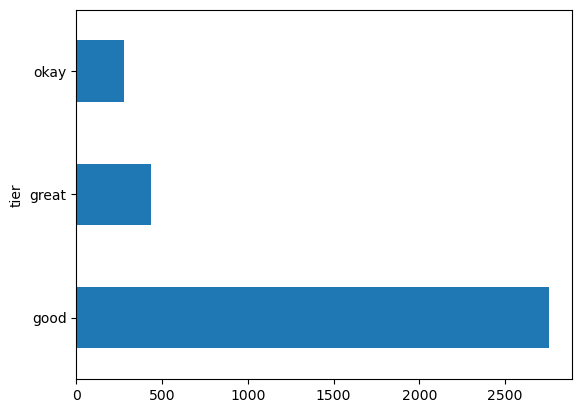

In [479]:
booking_new.groupby("tier")["hotel_name"].count().plot.barh()

Therefore, we see that there are 434 hotels that are "great" (9 or 10 star rating), 2754 that are "good" (7-8 star rating), and just 277 hotels that are "okay" (6 or less stars). If we can combine the two datasets, we can analyze the reviews with text analysis to see what key words are in each tier of hotels.

Let's attempt to join the two datasets - but before doing so, we need to standardize the hotel_name column to join on.

In [481]:
#function to remove punctuation and lowercase hotel_name column
import string
def clean_string(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
        text = text.lower()
    return text

#test function
clean_string('MY, NAme, is!!! Sarah....')



'my name is sarah'

In [482]:
# Now we can apply our function to the hotel_name in both datasets
booking_new['hotel_name']= booking_new['hotel_name'].apply(clean_string)
tripadvisor_new['hotel_name']=tripadvisor_new['hotel_name'].apply(clean_string)

In [483]:
#Next step... combine datasets with inner join 
join = pd.merge(tripadvisor_new, booking_new, on='hotel_name', how='inner')
join.head()
join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price_x        6 non-null      float64
 1   num_reviews_x  6 non-null      int64  
 2   review         6 non-null      object 
 3   hotel_name     6 non-null      object 
 4   city_x         0 non-null      object 
 5   rating         6 non-null      float64
 6   review_score   6 non-null      object 
 7   num_reviews_y  6 non-null      float64
 8   room_score     6 non-null      float64
 9   room_type      6 non-null      object 
 10  bed_type       6 non-null      object 
 11  price_y        6 non-null      int64  
 12  Area           6 non-null      object 
 13  city_y         6 non-null      object 
 14  tier           6 non-null      object 
dtypes: float64(4), int64(2), object(9)
memory usage: 852.0+ bytes


Well... considering that the datasets only share 6 hotels in common.. There's not much that we can do regarding text analysis. However, we were able to clean the datasets to a workable format for other types of analysis. 

FINAL THOUGHTS:

Though the datasets did not overlap as much as one would like, this was a great exercise in data cleaning and munging for further analysis. We were able to standardize columns, change data types, remove unnecessary characters, and split columns into a normalized format. These are very useful skills for future data analysis. I hope you enjoyed reviewing this code!